In [2]:
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
%aimport cca_compare
%aimport irmad

from scipy.stats import multivariate_normal
from collections import defaultdict

import gdal
import gdalio
from sklearn.cross_decomposition import CCA
import scipy as sc
from scipy import stats
from scipy.spatial.distance import cosine

Populating the interactive namespace from numpy and matplotlib


# Preparation
## Load dataset filenames

In [3]:
# load test dataset

import csv

with open("test_files_aligned.csv",'r') as f:
    reader = csv.reader(f.readlines())
    next(reader) # skip header
    test_pairs = [i for i in reader]
    print(len(test_pairs),'pairs loaded')

59 pairs loaded


## Set sample images

In [4]:
f1, f2 = test_pairs[6]
img1, img2 = gdalio.readAsArray(gdal.Open(f1)), gdalio.readAsArray(gdal.Open(f2))

In [5]:
def calc_cca(X,Y):
    n_bands = X.shape[1]
    cca_calc = new_CCA.CCA(n_bands)
    cca_calc.push(img1.reshape(-1,n_bands),img2.reshape(-1,n_bands))
    a,b,reg = cca_calc.calc()
    return cca_calc.transform(img1.reshape(-1,n_bands),img2.reshape(-1,n_bands))

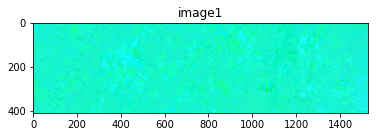

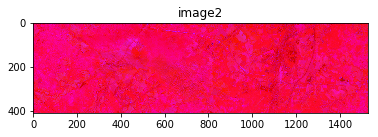

In [6]:
def get_percentille(x,y,band,p):
    if p < 50:
        return min(np.percentile(np.ravel(x[:,:,band]),p),np.percentile(np.ravel(y[:,:,band]),p))
    else:
        return max(np.percentile(np.ravel(x[:,:,band]),p),np.percentile(np.ravel(y[:,:,band]),p))

def fix_image(img,p=1):
    pmin = np.percentile(img,p)
    pmax = np.percentile(img,100-p)
    
    img = (img-pmin)/(pmax-pmin)
    img[img<0] = 0
    img[img>1] = 1
    return img

def get_display_images(img1,img2,p=1):
    n_bands = img1.shape[2]
    cca_calc = new_CCA.CCA(n_bands)
    cca_calc.push(img1.reshape(-1,n_bands),img2.reshape(-1,n_bands))
    a,b,reg = cca_calc.calc()
    img1_display, img2_display = cca_calc.transform(img1.reshape(-1,n_bands),img2.reshape(-1,n_bands))
    img1_display = img1_display.reshape(img1.shape)[:,:,:3]
    img2_display = img2_display.reshape(img2.shape)[:,:,:3]

    lower_p = np.array( [ get_percentille( img1_display, img2_display, i, p ) for i in range(3) ] )
    higher_p = np.array( [ get_percentille( img1_display, img2_display, i, 100-p ) for i in range(3) ] )
    img1_display = (img1_display-lower_p)/(higher_p-lower_p)
    img2_display = (img2_display-lower_p)/(higher_p-lower_p)
    img1_display[img1_display>1] = 1
    img2_display[img2_display>1] = 1
    img1_display[img1_display<0] = 0
    img2_display[img2_display<0] = 0
    
    return img1_display,img2_display
    
img1_display, img2_display = get_display_images(img1,img2)
title("image1")
imshow(img1_display);
show();
title("image2")
imshow(img2_display);
show();

# First iteration

In [7]:
correlation_change = []
n_bands = img1.shape[2]
X = img1.reshape(-1,n_bands)
Y = img2.reshape(-1,n_bands)
P = np.ones(X.shape[0])

cca = new_CCA.CCA(n_bands)
cca.push(X,Y)
cca.calc()
U,V = cca.transform(X,Y,apply_intercept=True)

# calculate difference and invert order, so most de-correlated instances are on the top
M = np.flip(U-V,1)
Z = (((M-np.mean(M,axis=0))/np.std(M,axis=0))**2).sum(axis=1)
P = 1-sc.stats.chi2.cdf( Z, n_bands, 0 )

# Gather stats
correlation_change.append( [ np.corrcoef( U[:,i], V[:,i] )[0,1] for i in range(n_bands) ] )

# Second iteration

In [8]:
X_weighted = X-X.mean(axis=0) # make 0-centered
X_weighted=X_weighted*np.sqrt(P[:,np.newaxis]) # apply weights
Y_weighted = Y-Y.mean(axis=0) # make 0-centered
Y_weighted=Y_weighted*np.sqrt(P[:,np.newaxis]) # apply weights

#cca.reset()
del cca
cca = new_CCA.CCA(n_bands)

cca.push(X_weighted,Y_weighted)
cca.calc()
U,V = cca.transform(X,Y,apply_intercept=False)

M = np.flip(U-V,1)
Z = (((M-np.mean(M,axis=0))/np.std(M,axis=0))**2).sum(axis=1)
P = 1-sc.stats.chi2.cdf( Z, n_bands, 0 )

# Gather stats
correlation_change.append( [ np.corrcoef( U[:,i], V[:,i] )[0,1] for i in range(n_bands) ] )

# Monitor

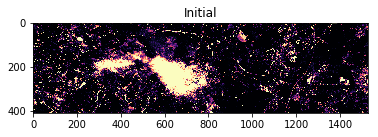

In [9]:
title("Initial")
figsize(15,15)
imshow( 1-P.reshape(img1.shape[:2]), cmap='magma', vmin=0,vmax=1 );

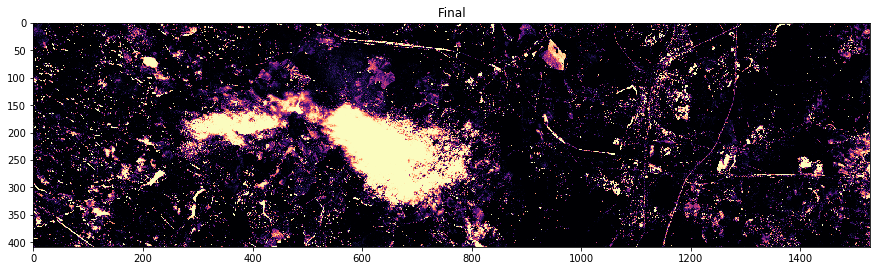

In [10]:
title("Final")
figsize(15,15)
imshow( 1-P.reshape(img1.shape[:2]), cmap='magma', vmin=0,vmax=1 );

In [11]:
correlation_change.append( [ np.corrcoef( U[:,i], V[:,i] )[0,1] for i in range(n_bands) ] )

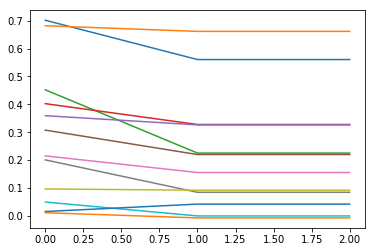

In [16]:
figsize(6,4)
plot( np.array(correlation_change) );

# Test new IRMAD

In [53]:
%aimport new_IRMAD

In [58]:
irmad = new_IRMAD.IRMAD( new_CCA.CCA(n_bands) )
irmad.push_data(X,Y)
irmad.commit_iteration()

In [60]:
proba = irmad.calc_nochange_proba(X,Y)

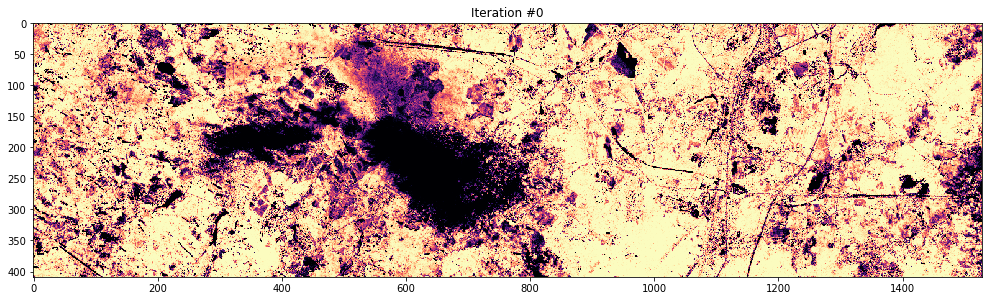

In [70]:
figsize(17,17);
title("Iteration #{}".format(irmad.iteration_num))
imshow(proba.reshape(img1.shape[0],img1.shape[1]),cmap='magma');